In [23]:
%matplotlib inline
import collections
import re
import random
import torch
from torch.nn import functional as F
import math
from d2l import torch as d2l


读取数据集

In [24]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')
def read_time_machine():

    with open(d2l.download("time_machine"), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'文本总行数：{len(lines)}')
print(lines[0])
print(lines[-1])

文本总行数：3221
the time machine by h g wells
of man


In [25]:
def tokenize(lines, token ='word'):
    if token == 'word':
        return [ line.split() for line in lines ]
    elif token == 'char':
        return [ list(line) for line in lines ]
    else:
        print('错误：未知词元类型：' + token)
        return None
    
tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [26]:
def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [27]:
counter = count_corpus(tokens)
token_freqs = sorted(counter.items(), key = lambda x:x[1], reverse = True)
token_freqs

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440),
 ('it', 437),
 ('had', 354),
 ('me', 281),
 ('as', 270),
 ('at', 243),
 ('for', 221),
 ('with', 216),
 ('but', 204),
 ('time', 200),
 ('were', 158),
 ('this', 152),
 ('you', 137),
 ('on', 137),
 ('then', 134),
 ('his', 129),
 ('there', 127),
 ('he', 123),
 ('have', 122),
 ('they', 122),
 ('from', 122),
 ('one', 120),
 ('all', 118),
 ('not', 114),
 ('into', 114),
 ('upon', 113),
 ('little', 113),
 ('so', 112),
 ('is', 106),
 ('came', 105),
 ('by', 103),
 ('some', 94),
 ('be', 93),
 ('no', 92),
 ('could', 92),
 ('their', 91),
 ('said', 89),
 ('saw', 88),
 ('down', 87),
 ('them', 86),
 ('machine', 85),
 ('which', 85),
 ('very', 85),
 ('or', 84),
 ('an', 84),
 ('we', 82),
 ('now', 79),
 ('what', 77),
 ('been', 75),
 ('these', 74),
 ('like', 74),
 ('her', 74),
 ('out', 73),
 ('seemed', 72),
 ('up', 71),
 ('man', 70),
 ('about', 70),
 ('s', 70),
 

In [28]:
class Vocab:  # 文本词表
    def __init__(self, tokens=None, min_freq=0, reversed_tokens = None):
        if tokens is None:
            tokens = []
        if reversed_tokens is None:
            reversed_tokens = []

        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key = lambda x:x[1], reverse = True)

        self.idx_to_token = ['<unk>'] + reversed_tokens
        self.token_to_idx = {token:idx for idx, token in enumerate(self.idx_to_token)}

        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) -1

    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list,tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices,(list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    @property
    def unk(self):
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs
    

In [29]:
vocab = Vocab(tokens)
#print(list(vocab.token_to_idx.items())[:10])
#print(vocab.token_to_idx.items())
len(vocab)

4580

In [30]:
for i in [0,10,15]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]
文本: ['luxurious', 'after', 'dinner', 'atmosphere', 'when', 'thought', 'roams', 'gracefully']
索引: [2196, 116, 289, 1424, 78, 76, 2197, 2198]


整合所有功能

In [31]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus),len(vocab)

(170580, 28)

自然语文统计

In [32]:
vocab.token_freqs[:10]

[(' ', 29927),
 ('e', 17838),
 ('t', 13515),
 ('a', 11704),
 ('i', 10138),
 ('n', 9917),
 ('o', 9758),
 ('s', 8486),
 ('h', 8257),
 ('r', 7674)]

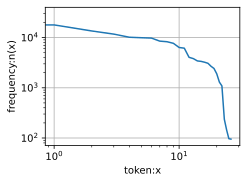

In [33]:
freqs = [ freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel="token:x", ylabel='frequency:n(x)', xscale='log', yscale='log')

In [34]:
corpus_word = [ token for line in tokens for token in line]
corpus_word[:10]

['the', 'time', 'machine', 'by', 'h', 'g', 'wells', 'i', 'the', 'time']

In [35]:
bigram_tokens = [pair for pair in zip(corpus_word[:-1], corpus_word[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

二元语法组合

In [36]:
bigram_tokens = [pair for pair in zip(corpus_word[:-1],corpus_word[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

三元语法组合

In [37]:
trigram_tokens =[triple for triple in zip(corpus_word[:],corpus_word[1:],corpus_word[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

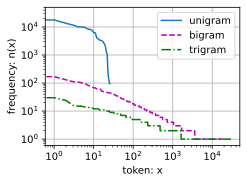

In [38]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

##### 读取长序列数据

随机采样

In [39]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

下面我们[**生成一个从$0$到$34$的序列**]。
假设批量大小为$2$，时间步数为$5$，这意味着可以生成
$\lfloor (35 - 1) / 5 \rfloor= 6$个“特征－标签”子序列对。
如果设置小批量大小为$2$，我们只能得到$3$个小批量。


In [40]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[17, 18, 19, 20, 21],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[18, 19, 20, 21, 22],
        [23, 24, 25, 26, 27]])
X:  tensor([[12, 13, 14, 15, 16],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]])
X:  tensor([[ 2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12]])


In [41]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [42]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]])
X:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])
X:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])


现在，我们[**将上面的两个采样函数包装到一个类中**]，
以便稍后可以将其用作数据迭代器。


In [43]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [44]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

# 循环神经网络的从零开始实现

In [45]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [65]:
k = torch.tensor([1,2])
k.shape


torch.Size([2])

In [55]:
kf = F.one_hot(k, 28)
kf

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [68]:
kf

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [70]:
X = torch.arange(10).reshape((2,5))
X


tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [74]:
X.T

tensor([[0, 5],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9]])

In [73]:
Y = F.one_hot(X.T, 28)
Y

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

初始化模型参数

隐藏单元数`num_hiddens`是一个可调的超参数。
当训练语言模型时，输入和输出来自相同的词表。
因此，它们具有相同的维度，即词表的大小。

In [75]:
def get_params(vocab_size, num_hiddens, device):

    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size = shape, device = device)*0.01
    
    #隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_inputs, num_hiddens))
    b_h = torch.zeros(num_hiddens,device=device)

    #输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs,device=device0)

    #附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

    
